In [1]:
import time

import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np


In [2]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16594455647497562794
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14465892352
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16184866237904804841
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [3]:
data_path = "/content/drive/Shareddrives/CS539 Group 6/data"

In [4]:
t0 = time.time()
with open(f"./combined.csv") as f:
  df = pd.read_csv(f)
t1 = time.time()

In [5]:
print((t1 - t0) / 60)

8.908048323790233


In [26]:
df_np = df.to_numpy()
df_np[:5, :10]

array([['no_tumor', 10, 10, 10, 10, 10, 10, 10, 10, 10],
       ['no_tumor', 0, 0, 0, 0, 0, 0, 0, 0, 0],
       ['no_tumor', 0, 0, 0, 0, 0, 0, 0, 0, 0],
       ['no_tumor', 0, 0, 0, 0, 0, 0, 0, 0, 0],
       ['no_tumor', 40, 40, 40, 40, 40, 40, 40, 40, 40]], dtype=object)

In [27]:
y = df_np[:, 0]

In [28]:
np.unique(y)

array(['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor'],
      dtype=object)

In [29]:
y[y == 'no_tumor'] = 0
y[y == 'meningioma_tumor'] = 1
y[y == 'glioma_tumor'] = 2
y[y == 'pituitary_tumor'] = 3
y = y.astype('float32')
X = df_np[:, 1:].astype('float32')
X_T = X.reshape(-1, 150, 150, 3)

In [30]:
np.unique(y)

array([0., 1., 2., 3.], dtype=float32)

In [31]:
Y = keras.utils.to_categorical(y)
# Y = y
X_train, X_test, y_train, y_test = train_test_split(X_T, Y)

In [32]:
y_train

array([[0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [33]:
image_size = 150
effnet = keras.applications.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [34]:
model = effnet.output
model = keras.layers.GlobalAveragePooling2D()(model)
model = keras.layers.Dropout(rate=0.5)(model)
model = keras.layers.Dense(4, activation='softmax')(model)
model = keras.models.Model(inputs=effnet.input, outputs=model)
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [55]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 150, 150, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 150, 150, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 151, 151, 3)  0           ['normalization[0][0]']      

In [35]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs=12, verbose=1, batch_size=32)

Epoch 1/12
166/166 [==============================] - 46s 169ms/step - loss: 0.3389 - accuracy: 0.8802 - val_loss: 0.3341 - val_accuracy: 0.8912
Epoch 2/12
166/166 [==============================] - 25s 152ms/step - loss: 0.1592 - accuracy: 0.9438 - val_loss: 0.5135 - val_accuracy: 0.8759
Epoch 3/12
166/166 [==============================] - 25s 154ms/step - loss: 0.0763 - accuracy: 0.9733 - val_loss: 0.2449 - val_accuracy: 0.9320
Epoch 4/12
166/166 [==============================] - 26s 155ms/step - loss: 0.0629 - accuracy: 0.9777 - val_loss: 0.7933 - val_accuracy: 0.8248
Epoch 5/12
166/166 [==============================] - 26s 157ms/step - loss: 0.0503 - accuracy: 0.9850 - val_loss: 0.5178 - val_accuracy: 0.8946
Epoch 6/12
166/166 [==============================] - 26s 157ms/step - loss: 0.1074 - accuracy: 0.9637 - val_loss: 0.4395 - val_accuracy: 0.9116
Epoch 7/12
166/166 [==============================] - 26s 157ms/step - loss: 0.0858 - accuracy: 0.9720 - val_loss: 0.0778 - val_ac

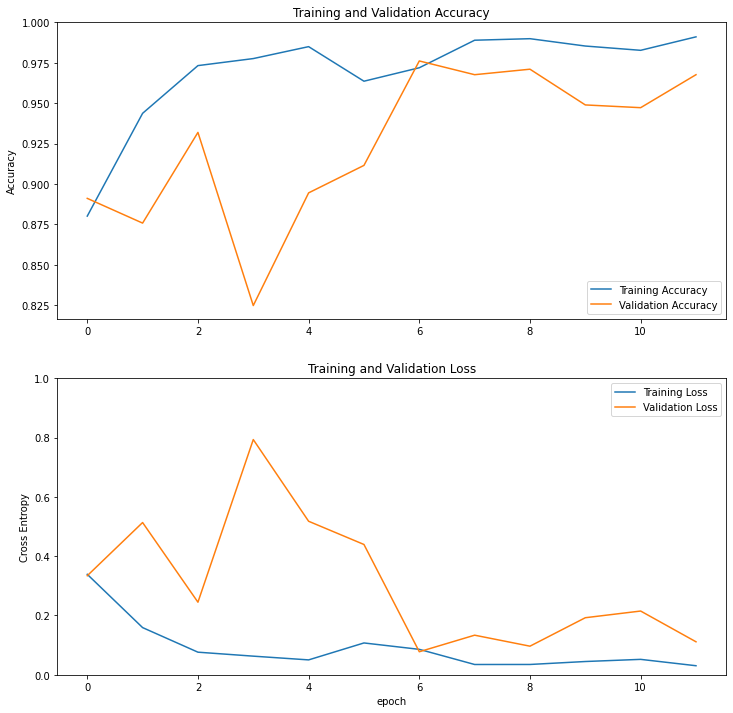

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [39]:
pred = model.predict(X_test)


In [44]:
pred.shape

array([5.2226356e-18, 7.7780996e-14, 1.0000000e+00, 5.9657859e-16],
      dtype=float32)

In [48]:
pred_argmax = np.argmax(pred, axis=1)
pred_argmax

array([2, 2, 1, ..., 1, 3, 0])

In [50]:
y_true = np.argmax(y_test, axis=1)
y_true

array([2, 2, 1, ..., 1, 3, 0])

In [51]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_true, pred_argmax))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       469
           1       0.96      0.91      0.94       422
           2       0.94      0.98      0.96       608
           3       0.98      0.98      0.98       458

    accuracy                           0.97      1957
   macro avg       0.97      0.97      0.97      1957
weighted avg       0.97      0.97      0.97      1957



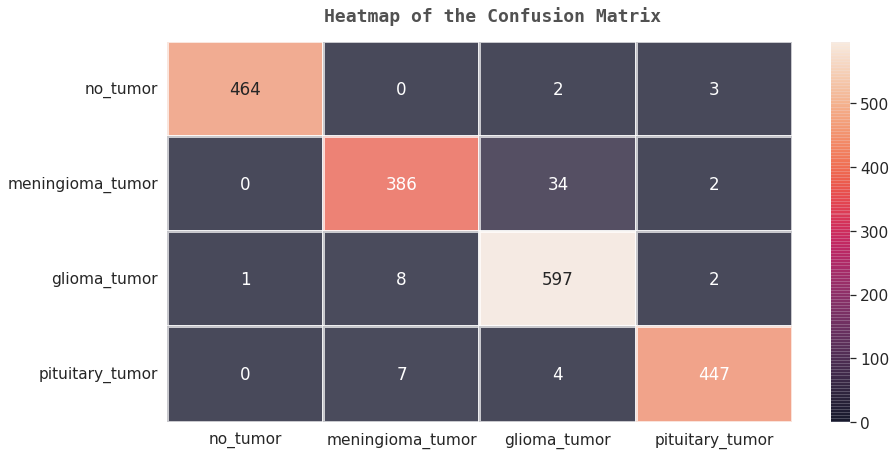

In [54]:
labels = ['no_tumor', 'meningioma_tumor', 'glioma_tumor', 'pituitary_tumor']

sns.set(font_scale=1.4)

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
sns.heatmap(confusion_matrix(y_true, pred_argmax), ax=ax, xticklabels=labels, yticklabels=labels, 
            annot=True, alpha=0.7, linewidths=2, fmt='g')
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.28,alpha=0.8)

plt.show()